# Analysis on the Spark Fund Data

In this section, we will conduct three types of analysis: funding type, country analysis, and sector analysis

### Funding Type Analysis

Lets compare the funding amount with funding types. Also, we need to impose the constraint that the investment amount be in between 5 and 15 million USD. We will choose the funding type such that the average investment amount falls in this range.

In [1]:
# Importing the necessary libraries:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading the data:

df = pd.read_csv("master_df.csv",sep=",",encoding="ISO-8859-1")
df.head()

,permalink,name,category_list,status,country_code,funding_round_permalink,funding_round_type,funded_at,raised_amount_usd
0,/organization/-fame,#fame,Media,operating,IND,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,05-01-2015,10000000.0
1,/organization/-qounter,:Qounter,Application Platforms|Real Time|Social Network...,operating,USA,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,01-03-2014,700000.0
2,/organization/0-6-com,0-6.com,Curated Web,operating,CHN,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,19-03-2008,2000000.0
3,/organization/01games-technology,01Games Technology,Games,operating,HKG,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,undisclosed,01-07-2014,41250.0
4,/organization/0ndine-biomedical-inc,Ondine Biomedical Inc.,Biotechnology,operating,CAN,/funding-round/2b9d3ac293d5cdccbecff5c8cb0f327d,seed,11-09-2009,43360.0


In [3]:
# Value counts for funding round type:

df["funding_round_type"].unique()

array(['venture', 'seed', 'undisclosed', 'convertible_note',
       'private_equity', 'debt_financing', 'angel', 'grant',
       'equity_crowdfunding', 'post_ipo_equity', 'post_ipo_debt',
       'product_crowdfunding', 'secondary_market',
       'non_equity_assistance'], dtype=object)

In [4]:
# We are concerned with "venture","seed","angel","private-equity"

df = df[(df.funding_round_type =="venture") |
        (df.funding_round_type == "angel") |
        (df.funding_round_type == "seed") |
        (df.funding_round_type == "private_equity")]

Now,we have to compute a representative value of the funding amount for each type of investment.We can either choose the mean or the median.Lets have a look at the distribution of the raised amount usd to get the sense of the distribution of the data. 

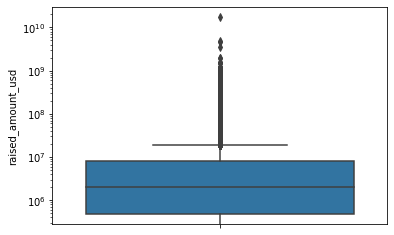

In [5]:
# Distribution of the raised amount usd:

sns.boxplot(y=df["raised_amount_usd"])
plt.yscale("log")

In [6]:
df["raised_amount_usd"].describe()

count    7.512400e+04
mean     9.519475e+06
std      7.792778e+07
min      0.000000e+00
25%      4.705852e+05
50%      2.000000e+06
75%      8.000000e+06
max      1.760000e+10
Name: raised_amount_usd, dtype: float64

The mean value is USD 9.51 million and the median is USD 2 million. There is a drastic difference between the mean and median amount raised.We need to treat for the outliers as we could see in the boxplot there are many outliers observed in the data.

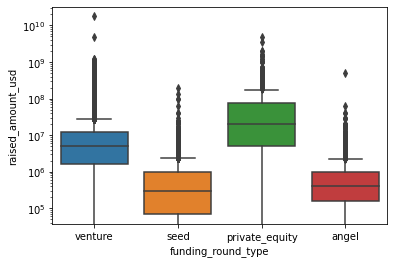

In [7]:
# plotting the boxplot for each funding type for checking the outliers:

sns.boxplot(x="funding_round_type",y="raised_amount_usd",data=df)
plt.yscale("log")

In [8]:
# Compare the mean and median across the categories:

df.pivot_table(values='raised_amount_usd', columns='funding_round_type', aggfunc=[np.median, np.mean])

median                                      \
funding_round_type     angel private_equity      seed    venture   
raised_amount_usd   414906.0     20000000.0  300000.0  5000000.0   

                             mean                                              
funding_round_type          angel private_equity           seed       venture  
raised_amount_usd   971573.891136   7.393849e+07  747793.682484  1.172422e+07

Note that there's a large difference between the mean and the median values for all four types. For type venture, for e.g. the median is about 20m while the mean is about 70m.

Thus, the choice of the summary statistic will drastically affect the decision (of the investment type). Let's choose median, since there are quite a few extreme values pulling the mean up towards them - but they are not the most 'representative' values.

In [9]:
# compare the median investment amount across the types
df.groupby('funding_round_type')['raised_amount_usd'].median().sort_values(ascending=False)

funding_round_type
private_equity    20000000.0
venture            5000000.0
angel               414906.0
seed                300000.0
Name: raised_amount_usd, dtype: float64

The median investment amount for type 'private_equity' is approx. USD 20m, which is beyond Spark Funds' range of 5-15m. The median of 'venture' type is about USD 5m, which is suitable for them. The average amounts of angel and seed types are lower than their range.

Thus, 'venture' type investment will be most suited to them.

### Country Analysis

Let's now compare the total investment amounts across countries. Note that we'll filter the data for only the 'venture' type investments and then compare the 'total investment' across countries.

In [10]:
# filter the df for private equity type investments

df = df[df.funding_round_type=="venture"]

# group by country codes and compare the total funding amounts

country_wise_total = df.groupby('country_code')['raised_amount_usd'].sum().sort_values(ascending=False)
print(country_wise_total)

country_code
USA    4.200680e+11
CHN    3.933892e+10
GBR    2.007281e+10
IND    1.426151e+10
CAN    9.482218e+09
           ...     
MCO    6.570000e+05
SAU    5.000000e+05
CMR    3.595610e+05
GTM    3.000000e+05
MMR    2.000000e+05
Name: raised_amount_usd, Length: 97, dtype: float64


In [11]:
# top 9 countries
top_9_countries = country_wise_total[:9]
top_9_countries

country_code
USA    4.200680e+11
CHN    3.933892e+10
GBR    2.007281e+10
IND    1.426151e+10
CAN    9.482218e+09
FRA    7.226851e+09
ISR    6.854350e+09
DEU    6.306922e+09
JPN    3.167647e+09
Name: raised_amount_usd, dtype: float64

Among the top 9 countries, USA, GBR and IND are the top three English speaking countries. Let's filter the dataframe so it contains only the top 3 countries.

In [12]:
# filtering for the top three countries
df = df[(df.country_code=='USA') | (df.country_code=='GBR') | (df.country_code=='IND')]
df.head()

,permalink,name,category_list,status,country_code,funding_round_permalink,funding_round_type,funded_at,raised_amount_usd
0,/organization/-fame,#fame,Media,operating,IND,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,05-01-2015,10000000.0
7,/organization/0xdata,H2O.ai,Analytics,operating,USA,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,09-11-2015,20000000.0
8,/organization/0xdata,H2O.ai,Analytics,operating,USA,/funding-round/ae2a174c06517c2394aed45006322a7e,venture,03-01-2013,1700000.0
9,/organization/0xdata,H2O.ai,Analytics,operating,USA,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,venture,19-07-2014,8900000.0
15,/organization/1-mainstream,1 Mainstream,Apps|Cable|Distribution|Software,acquired,USA,/funding-round/b952cbaf401f310927430c97b68162ea,venture,17-03-2015,5000000.0


After filtering for 'venture' investments and the three countries USA, Great Britain and India, the filtered df looks like this.

In [13]:
# Information of the df:

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38803 entries, 0 to 88517
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   permalink                38803 non-null  object 
 1   name                     38803 non-null  object 
 2   category_list            38803 non-null  object 
 3   status                   38803 non-null  object 
 4   country_code             38803 non-null  object 
 5   funding_round_permalink  38803 non-null  object 
 6   funding_round_type       38803 non-null  object 
 7   funded_at                38803 non-null  object 
 8   raised_amount_usd        38803 non-null  float64
dtypes: float64(1), object(8)
memory usage: 3.0+ MB


One can visually analyse the distribution and the total values of funding amount.

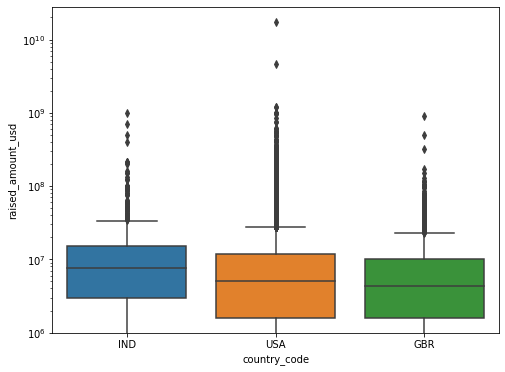

In [16]:
# boxplot to see distributions of funding amount across countries
plt.figure(figsize=(8, 6))
sns.boxplot(x='country_code', y='raised_amount_usd', data=df)
plt.yscale('log')
plt.show()

Now, we have shortlisted the investment type (venture) and the three countries. Let's now choose the sectors.

### Sector Analysis

First, we need to extract the main sector using the column category_list. The category_list column contains values such as 'Biotechnology|Health Care' - in this, 'Biotechnology' is the 'main category' of the company, which we need to use.

Let's extract the main categories in a new column.

In [17]:
# extracting the main category
df.loc[:, 'main_category'] = df['category_list'].apply(lambda x: x.split("|")[0])
df.head()

,permalink,name,category_list,status,country_code,funding_round_permalink,funding_round_type,funded_at,raised_amount_usd,main_category
0,/organization/-fame,#fame,Media,operating,IND,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,05-01-2015,10000000.0,Media
7,/organization/0xdata,H2O.ai,Analytics,operating,USA,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,09-11-2015,20000000.0,Analytics
8,/organization/0xdata,H2O.ai,Analytics,operating,USA,/funding-round/ae2a174c06517c2394aed45006322a7e,venture,03-01-2013,1700000.0,Analytics
9,/organization/0xdata,H2O.ai,Analytics,operating,USA,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,venture,19-07-2014,8900000.0,Analytics
15,/organization/1-mainstream,1 Mainstream,Apps|Cable|Distribution|Software,acquired,USA,/funding-round/b952cbaf401f310927430c97b68162ea,venture,17-03-2015,5000000.0,Apps


We can now drop the category_list column.

In [18]:
# drop the category_list column
df = df.drop('category_list', axis=1)
df.head()

,permalink,name,status,country_code,funding_round_permalink,funding_round_type,funded_at,raised_amount_usd,main_category
0,/organization/-fame,#fame,operating,IND,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,05-01-2015,10000000.0,Media
7,/organization/0xdata,H2O.ai,operating,USA,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,09-11-2015,20000000.0,Analytics
8,/organization/0xdata,H2O.ai,operating,USA,/funding-round/ae2a174c06517c2394aed45006322a7e,venture,03-01-2013,1700000.0,Analytics
9,/organization/0xdata,H2O.ai,operating,USA,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,venture,19-07-2014,8900000.0,Analytics
15,/organization/1-mainstream,1 Mainstream,acquired,USA,/funding-round/b952cbaf401f310927430c97b68162ea,venture,17-03-2015,5000000.0,Apps


Now, we'll read the mapping.csv file and merge the main categories with its corresponding column.

In [20]:
# read mapping file
mapping = pd.read_csv("mapping.csv", sep=",")
mapping.head()

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,0,1


Firstly, let's get rid of the missing values since we'll not be able to merge those rows anyway.

In [21]:
# missing values in mapping file
mapping.isnull().sum()

category_list                              1
Automotive & Sports                        0
Blanks                                     0
Cleantech / Semiconductors                 0
Entertainment                              0
Health                                     0
Manufacturing                              0
News, Search and Messaging                 0
Others                                     0
Social, Finance, Analytics, Advertising    0
dtype: int64

In [22]:
# remove the row with missing values
mapping = mapping[~pd.isnull(mapping['category_list'])]
mapping.isnull().sum()

category_list                              0
Automotive & Sports                        0
Blanks                                     0
Cleantech / Semiconductors                 0
Entertainment                              0
Health                                     0
Manufacturing                              0
News, Search and Messaging                 0
Others                                     0
Social, Finance, Analytics, Advertising    0
dtype: int64

Now, since we need to merge the mapping file with the main dataframe (df), let's convert the common column to lowercase in both.

In [24]:
# converting common columns to lowercase
mapping['category_list'] = mapping['category_list'].str.lower()
df['main_category'] = df['main_category'].str.lower()

In [25]:
# look at heads
print(mapping.head())

      category_list  Automotive & Sports  Blanks  Cleantech / Semiconductors  \
1                3d                    0       0                           0   
2       3d printing                    0       0                           0   
3     3d technology                    0       0                           0   
4        accounting                    0       0                           0   
5  active lifestyle                    0       0                           0   

   Entertainment  Health  Manufacturing  News, Search and Messaging  Others  \
1              0       0              1                           0       0   
2              0       0              1                           0       0   
3              0       0              1                           0       0   
4              0       0              0                           0       0   
5              0       1              0                           0       0   

   Social, Finance, Analytics, Advertising  

In [26]:
print(df.head())

                     permalink          name     status country_code  \
0          /organization/-fame         #fame  operating          IND   
7         /organization/0xdata        H2O.ai  operating          USA   
8         /organization/0xdata        H2O.ai  operating          USA   
9         /organization/0xdata        H2O.ai  operating          USA   
15  /organization/1-mainstream  1 Mainstream   acquired          USA   

                            funding_round_permalink funding_round_type  \
0   /funding-round/9a01d05418af9f794eebff7ace91f638            venture   
7   /funding-round/3bb2ee4a2d89251a10aaa735b1180e44            venture   
8   /funding-round/ae2a174c06517c2394aed45006322a7e            venture   
9   /funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e            venture   
15  /funding-round/b952cbaf401f310927430c97b68162ea            venture   

     funded_at  raised_amount_usd main_category  
0   05-01-2015         10000000.0         media  
7   09-11-2015        

Let's have a look at the category_list column of the mapping file. These values will be used to merge with the main df.

In [28]:
mapping['category_list']

1                    3d
2           3d printing
3         3d technology
4            accounting
5      active lifestyle
             ...       
683           wholesale
684    wine and spirits
685            wireless
686               women
687        young adults
Name: category_list, Length: 687, dtype: object

To be able to merge all the main_category values with the mapping file's category_list column, all the values in the main_category column should be present in the category_list column of the mapping file.

Let's see if this is true.

In [29]:
# values in main_category column in df which are not in the category_list column in mapping file
df[~df['main_category'].isin(mapping['category_list'])]

,permalink,name,status,country_code,funding_round_permalink,funding_round_type,funded_at,raised_amount_usd,main_category
7,/organization/0xdata,H2O.ai,operating,USA,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,09-11-2015,20000000.0,analytics
8,/organization/0xdata,H2O.ai,operating,USA,/funding-round/ae2a174c06517c2394aed45006322a7e,venture,03-01-2013,1700000.0,analytics
9,/organization/0xdata,H2O.ai,operating,USA,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,venture,19-07-2014,8900000.0,analytics
47,/organization/100plus,100Plus,acquired,USA,/funding-round/b5facb0d9dea2f0352b5834892c88c53,venture,02-11-2011,500000.0,analytics
136,/organization/1world-online,1World Online,operating,USA,/funding-round/32936e588a134502712877150198a0b3,venture,13-08-2015,2500000.0,analytics
...,...,...,...,...,...,...,...,...,...
88269,/organization/zoopla,Zoopla,ipo,GBR,/funding-round/98da1f441a55c9a9629a256828923e38,venture,19-01-2009,5440000.0,property management
88290,/organization/zopa,Zopa,operating,GBR,/funding-round/2a55d435c3433d8f903526c050c19361,venture,20-03-2007,12900000.0,finance
88291,/organization/zopa,Zopa,operating,GBR,/funding-round/4b0740cb83da8d2af9d221e5455f8923,venture,01-03-2006,15000000.0,finance
88292,/organization/zopa,Zopa,operating,GBR,/funding-round/54dbfbd899caf7d1d4b2b7676065f303,venture,01-07-2006,5000000.0,finance


Notice that values such as 'analytics', 'business analytics', 'finance', 'nanatechnology' etc. are not present in the mapping file.

Let's have a look at the values which are present in the mapping file but not in the main dataframe df.

In [30]:
# values in the category_list column which are not in main_category column 
mapping[~mapping['category_list'].isin(df['main_category'])]

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
16,air pollution control,0,0,1,0,0,0,0,0,0
20,alter0tive medicine,0,0,0,0,1,0,0,0,0
22,a0lytics,0,0,0,0,0,0,0,0,1
33,aquaculture,0,0,1,0,0,0,0,0,0
49,b2b express delivery,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
670,virtual workforces,0,0,0,1,0,0,0,0,0
672,waste ma0gement,0,0,1,0,0,0,0,0,0
682,weddings,0,0,0,1,0,0,0,0,0
683,wholesale,0,0,0,0,0,0,0,1,0


If you see carefully, you'll notice something fishy - there are sectors named alter0tive medicine, a0lytics, waste ma0gement, veteri0ry, etc. This is not a random quality issue, but rather a pattern. In some strings, the 'na' has been replaced by '0'. This is weird - maybe someone was trying to replace the 'NA' values with '0', and ended up doing this.

Let's treat this problem by replacing '0' with 'na' in the category_list column.

In [31]:
# replacing '0' with 'na'
mapping['category_list'] = mapping['category_list'].apply(lambda x: x.replace('0', 'na'))
print(mapping['category_list'])

1                    3d
2           3d printing
3         3d technology
4            accounting
5      active lifestyle
             ...       
683           wholesale
684    wine and spirits
685            wireless
686               women
687        young adults
Name: category_list, Length: 687, dtype: object


In [32]:
# merge the dfs
df = pd.merge(df, mapping, how='inner', left_on='main_category', right_on='category_list')
df.head()

,permalink,name,status,country_code,funding_round_permalink,funding_round_type,funded_at,raised_amount_usd,main_category,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,/organization/-fame,#fame,operating,IND,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,05-01-2015,10000000.0,media,media,0,0,0,1,0,0,0,0,0
1,/organization/90min,90min,operating,GBR,/funding-round/21a2cbf6f2fb2a1c2a61e04bf930dfe6,venture,06-10-2015,15000000.0,media,media,0,0,0,1,0,0,0,0,0
2,/organization/90min,90min,operating,GBR,/funding-round/bd626ed022f5c66574b1afe234f3c90d,venture,07-05-2013,5800000.0,media,media,0,0,0,1,0,0,0,0,0
3,/organization/90min,90min,operating,GBR,/funding-round/fd4b15e8c97ee2ffc0acccdbe1a98810,venture,26-03-2014,18000000.0,media,media,0,0,0,1,0,0,0,0,0
4,/organization/all-def-digital,All Def Digital,operating,USA,/funding-round/452a2342fe720285c3b92e9bd927d9ba,venture,06-08-2014,5000000.0,media,media,0,0,0,1,0,0,0,0,0


In [33]:
# let's drop the category_list column since it is the same as main_category
df = df.drop('category_list', axis=1)
df.head()

,permalink,name,status,country_code,funding_round_permalink,funding_round_type,funded_at,raised_amount_usd,main_category,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,/organization/-fame,#fame,operating,IND,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,05-01-2015,10000000.0,media,0,0,0,1,0,0,0,0,0
1,/organization/90min,90min,operating,GBR,/funding-round/21a2cbf6f2fb2a1c2a61e04bf930dfe6,venture,06-10-2015,15000000.0,media,0,0,0,1,0,0,0,0,0
2,/organization/90min,90min,operating,GBR,/funding-round/bd626ed022f5c66574b1afe234f3c90d,venture,07-05-2013,5800000.0,media,0,0,0,1,0,0,0,0,0
3,/organization/90min,90min,operating,GBR,/funding-round/fd4b15e8c97ee2ffc0acccdbe1a98810,venture,26-03-2014,18000000.0,media,0,0,0,1,0,0,0,0,0
4,/organization/all-def-digital,All Def Digital,operating,USA,/funding-round/452a2342fe720285c3b92e9bd927d9ba,venture,06-08-2014,5000000.0,media,0,0,0,1,0,0,0,0,0


In [34]:
# look at the column types and names
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38788 entries, 0 to 38787
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   permalink                                38788 non-null  object 
 1   name                                     38788 non-null  object 
 2   status                                   38788 non-null  object 
 3   country_code                             38788 non-null  object 
 4   funding_round_permalink                  38788 non-null  object 
 5   funding_round_type                       38788 non-null  object 
 6   funded_at                                38788 non-null  object 
 7   raised_amount_usd                        38788 non-null  float64
 8   main_category                            38788 non-null  object 
 9   Automotive & Sports                      38788 non-null  int64  
 10  Blanks                                   38788

### Converting the 'wide' dataframe to 'long'

You'll notice that the columns representing the main category in the mapping file are originally in the 'wide' format - Automotive & Sports, Cleantech / Semiconductors etc.

They contain the value '1' if the company belongs to that category, else 0. This is quite redundant. We can as well have a column named 'sub-category' having these values.

Let's convert the df into the long format from the current wide format. First, we'll store the 'value variables' (those which are to be melted) in an array. The rest will then be the 'index variables'.

In [35]:
help(pd.melt)

Help on function melt in module pandas.core.reshape.melt:

melt(frame: 'DataFrame', id_vars=None, value_vars=None, var_name=None, value_name='value', col_level=None, ignore_index: 'bool' = True) -> 'DataFrame'
    Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.
    
    This function is useful to massage a DataFrame into a format where one
    or more columns are identifier variables (`id_vars`), while all other
    columns, considered measured variables (`value_vars`), are "unpivoted" to
    the row axis, leaving just two non-identifier columns, 'variable' and
    'value'.
    
    Parameters
    ----------
    id_vars : tuple, list, or ndarray, optional
        Column(s) to use as identifier variables.
    value_vars : tuple, list, or ndarray, optional
        Column(s) to unpivot. If not specified, uses all columns that
        are not set as `id_vars`.
    var_name : scalar
        Name to use for the 'variable' column. If None it uses
        ``fr

In [36]:
# store the value and id variables in two separate arrays

# store the value variables in one Series
value_vars = df.columns[9:18]

# take the setdiff() to get the rest of the variables
id_vars = np.setdiff1d(df.columns, value_vars)

print(value_vars, "\n")
print(id_vars)

Index(['Automotive & Sports', 'Blanks', 'Cleantech / Semiconductors',
       'Entertainment', 'Health', 'Manufacturing',
       'News, Search and Messaging', 'Others',
       'Social, Finance, Analytics, Advertising'],
      dtype='object') 

['country_code' 'funded_at' 'funding_round_permalink' 'funding_round_type'
 'main_category' 'name' 'permalink' 'raised_amount_usd' 'status']


In [37]:
# convert into long
long_df = pd.melt(df, 
        id_vars=list(id_vars), 
        value_vars=list(value_vars))

long_df.head()

,country_code,funded_at,funding_round_permalink,funding_round_type,main_category,name,permalink,raised_amount_usd,status,variable,value
0,IND,05-01-2015,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,media,#fame,/organization/-fame,10000000.0,operating,Automotive & Sports,0
1,GBR,06-10-2015,/funding-round/21a2cbf6f2fb2a1c2a61e04bf930dfe6,venture,media,90min,/organization/90min,15000000.0,operating,Automotive & Sports,0
2,GBR,07-05-2013,/funding-round/bd626ed022f5c66574b1afe234f3c90d,venture,media,90min,/organization/90min,5800000.0,operating,Automotive & Sports,0
3,GBR,26-03-2014,/funding-round/fd4b15e8c97ee2ffc0acccdbe1a98810,venture,media,90min,/organization/90min,18000000.0,operating,Automotive & Sports,0
4,USA,06-08-2014,/funding-round/452a2342fe720285c3b92e9bd927d9ba,venture,media,All Def Digital,/organization/all-def-digital,5000000.0,operating,Automotive & Sports,0


In [38]:
# remove rows having value=0
long_df = long_df[long_df['value']==1]
long_df = long_df.drop('value', axis=1)

In [39]:
# look at the new df
long_df.head()
len(long_df)

38788

In [40]:
# renaming the 'variable' column
long_df = long_df.rename(columns={'variable': 'sector'})

In [42]:
#info
long_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38788 entries, 25828 to 349075
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   country_code             38788 non-null  object 
 1   funded_at                38788 non-null  object 
 2   funding_round_permalink  38788 non-null  object 
 3   funding_round_type       38788 non-null  object 
 4   main_category            38788 non-null  object 
 5   name                     38788 non-null  object 
 6   permalink                38788 non-null  object 
 7   raised_amount_usd        38788 non-null  float64
 8   status                   38788 non-null  object 
 9   sector                   38788 non-null  object 
dtypes: float64(1), object(9)
memory usage: 3.3+ MB


The dataframe now contains only venture type investments in countries USA, IND and GBR, and we have mapped each company to one of the eight main sectors (named 'sector' in the dataframe).

We can now compute the sector-wise number and the amount of investment in the three countries.

In [43]:
# summarising the sector-wise number and sum of venture investments across three countries

# first, let's also filter for investment range between 5 and 15m
df = long_df[(long_df['raised_amount_usd'] >= 5000000) & (long_df['raised_amount_usd'] <= 15000000)]

In [44]:
# groupby country, sector and compute the count and sum
df.groupby(['country_code', 'sector']).raised_amount_usd.agg(['count', 'sum'])

count           sum
country_code sector                                                      
GBR          Automotive & Sports                         16  1.670516e+08
             Cleantech / Semiconductors                 130  1.163990e+09
             Entertainment                               56  4.827847e+08
             Health                                      24  2.145375e+08
             Manufacturing                               42  3.619403e+08
             News, Search and Messaging                  73  6.157462e+08
             Others                                     147  1.283624e+09
             Social, Finance, Analytics, Advertising    133  1.089404e+09
IND          Automotive & Sports                         13  1.369000e+08
             Cleantech / Semiconductors                  20  1.653800e+08
             Entertainment                               33  2.808300e+08
             Health                                      19  1.677400e+08
             Manufacturing                               21  2.009000e+08
             News, Search and Messaging                  52  4.338345e+08
             Others                                     110  1.013410e+09
             Social, Finance, Analytics, Advertising     60  5.505496e+08
USA          Automotive & Sports                        167  1.454104e+09
             Cleantech / Semiconductors                2350  2.163343e+10
             Entertainment                              591  5.099198e+09
             Health                                     909  8.211859e+09
             Manufacturing                              799  7.258553e+09
             News, Search and Messaging                1583  1.397157e+10
             Others                                    2950  2.632101e+10
             Social, Finance, Analytics, Advertising   2714  2.380738e+10

This will be much more easy to understand using a plot.

Text(0.5, 1.0, 'Number of Investments')

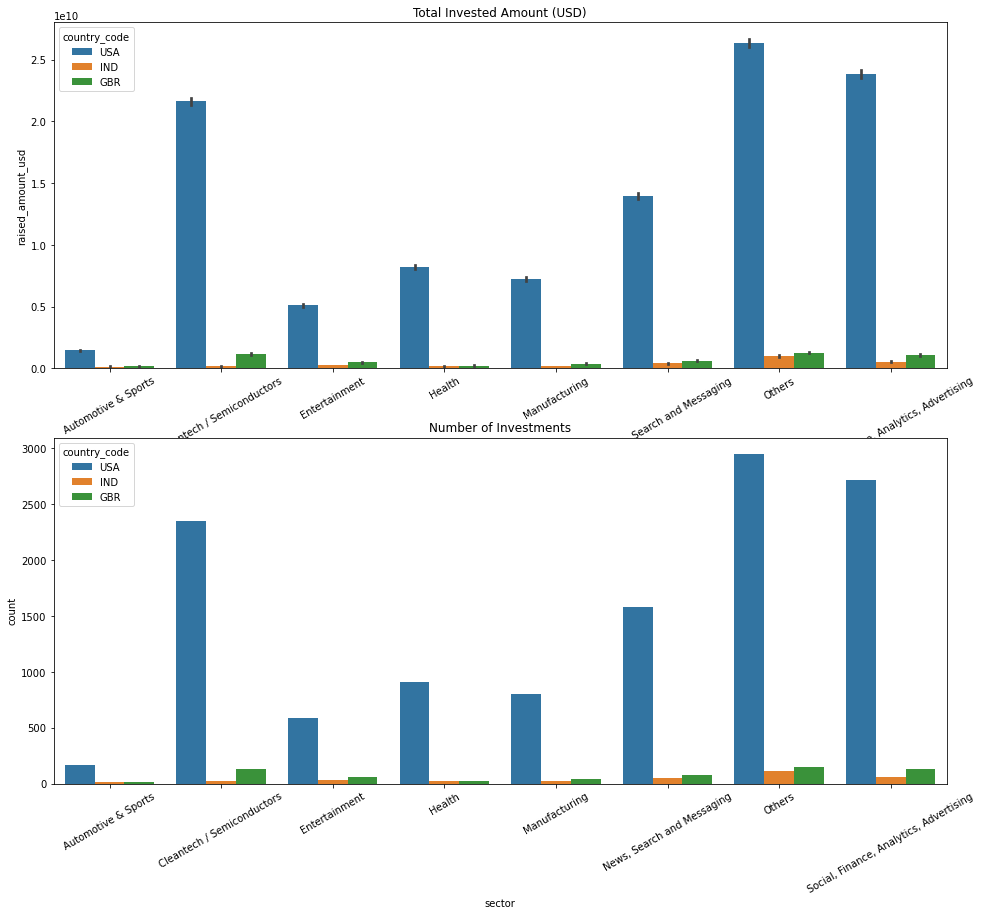

In [45]:
# plotting sector-wise count and sum of investments in the three countries
plt.figure(figsize=(16, 14))

plt.subplot(2, 1, 1)
p = sns.barplot(x='sector', y='raised_amount_usd', hue='country_code', data=df, estimator=np.sum)
p.set_xticklabels(p.get_xticklabels(),rotation=30)
plt.title('Total Invested Amount (USD)')

plt.subplot(2, 1, 2)
q = sns.countplot(x='sector', hue='country_code', data=df)
q.set_xticklabels(q.get_xticklabels(),rotation=30)
plt.title('Number of Investments')

Thus, the top country in terms of the number of investments (and the total amount invested) is the USA. The sectors 'Others', 'Social, Finance, Analytics and Advertising' and 'Cleantech/Semiconductors' are the most heavily invested ones.

In case you don't want to consider 'Others' as a sector, 'News, Search and Messaging' is the next best sector.